In [1]:
%load_ext autoreload
%autoreload 2

if __name__ == '__main__':
    import sys
    import os
    from pathlib import Path
    curr_file_path = Path(os.path.abspath(''))
    sys.path.append(str(curr_file_path.parent))

import numpy as np
import glob2 as glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.decomposition import PCA
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from aux_funcs import colored_line, compressed_read, logical_and, compressed_write, format_plot, add_pc_axes, format_pc_plot, make_path_if_not_exists, cum_sum, compute_cosine_sims
from nb_analysis_tools import load_hidden_and_behavior

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['font.family'] = 'Helvetica Light'

color_high_reward = '#d95f02'
color_low_reward = '#1b9e77'
color_unrewarded = '#7570b3'
color_intersite = '#808080'
color_interpatch = '#b3b3b3'

odor_colors = [
    color_unrewarded,
    color_low_reward,
    color_high_reward,
]

In [2]:
dir_path = '../../results/rl_agent_outputs/test_he_init_0p1_922161_2025-04-22_09_01_08_731132_var_noise_0_activity_weight_0'

In [3]:
hidden, pc_activities, all_session_data, flattened_hidden, pca = load_hidden_and_behavior(dir_path)

['00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']


In [4]:
env_idx = 0
session_data = all_session_data[env_idx]

Axes(0.125,0.11;0.775x0.77)


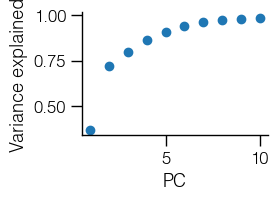

In [54]:
scale = 0.4
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

var_exp = cum_sum(pca.explained_variance_ratio_)

axs.scatter(np.arange(1, 11), var_exp[:10])
axs.set_ylabel('Variance explained')
axs.set_xlabel('PC')
format_plot(axs)
fig.savefig('../../results/figures/cum_explained_variance_he_init.svg', bbox_inches='tight')
fig.savefig('../../results/figures/cum_explained_variance_he_init.png', bbox_inches='tight')

[<Axes: > <Axes: > <Axes: > <Axes: >]
[<Axes: xlabel='PC 1', ylabel='PC 2'>, <Axes: xlabel='PC 3', ylabel='PC 4'>, <Axes: xlabel='PC 5', ylabel='PC 6'>, <Axes: xlabel='PC 7', ylabel='PC 8'>]


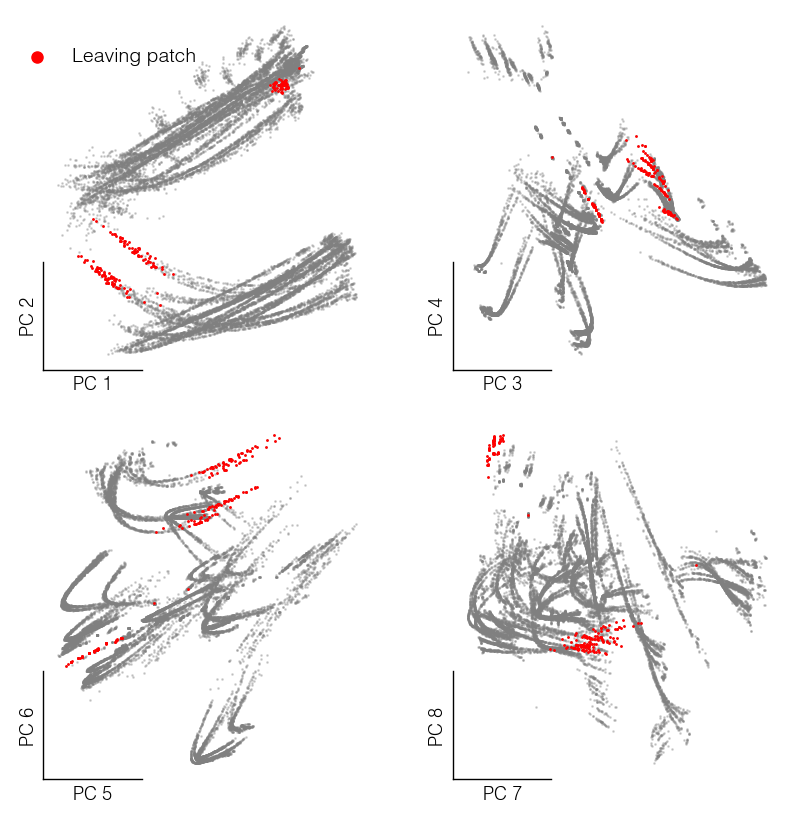

In [6]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(7 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    k_x, k_y = int(k/4), int(k/2) % 2
    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :][session_data['agent_in_patch'] <= 0],
        pc_activities[k+1, env_idx, :][session_data['agent_in_patch'] <= 0],
        s=1,
        c='grey',
        alpha=0.3,
    )

    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :][session_data['agent_in_patch'] > 0],
        pc_activities[k+1, env_idx, :][session_data['agent_in_patch'] > 0],
        s=1,
        c='grey',
        alpha=0.3,
    )

    leaving_site_mask = logical_and(
        session_data['agent_in_patch'] == 1,
        np.roll(session_data['agent_in_patch'], -1) == 0,
    )

    extra_args = {}
    if k == 0:
        extra_args['label'] = 'Leaving patch'

    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :][leaving_site_mask],
        pc_activities[k+1, env_idx, :][leaving_site_mask],
        s=1,
        c='red',
        zorder=5,
        **extra_args,
    )
legend = fig.legend(markerscale=8, bbox_to_anchor=(0.3, .95), fontsize=14, frameon=False)
fig.tight_layout()
# axs[0, 0].set_title('Activity colored by rewards seen in patch')
# fig.tight_layout()
format_pc_plot(axs)
fig.savefig('../../results/figures/pc_patch_leaving_he_init.svg')
fig.savefig('../../results/figures/pc_patch_leaving_he_init.png')

[<Axes: > <Axes: > <Axes: > <Axes: >]
[<Axes: xlabel='PC 1', ylabel='PC 2'>, <Axes: xlabel='PC 3', ylabel='PC 4'>, <Axes: xlabel='PC 5', ylabel='PC 6'>, <Axes: xlabel='PC 7', ylabel='PC 8'>]


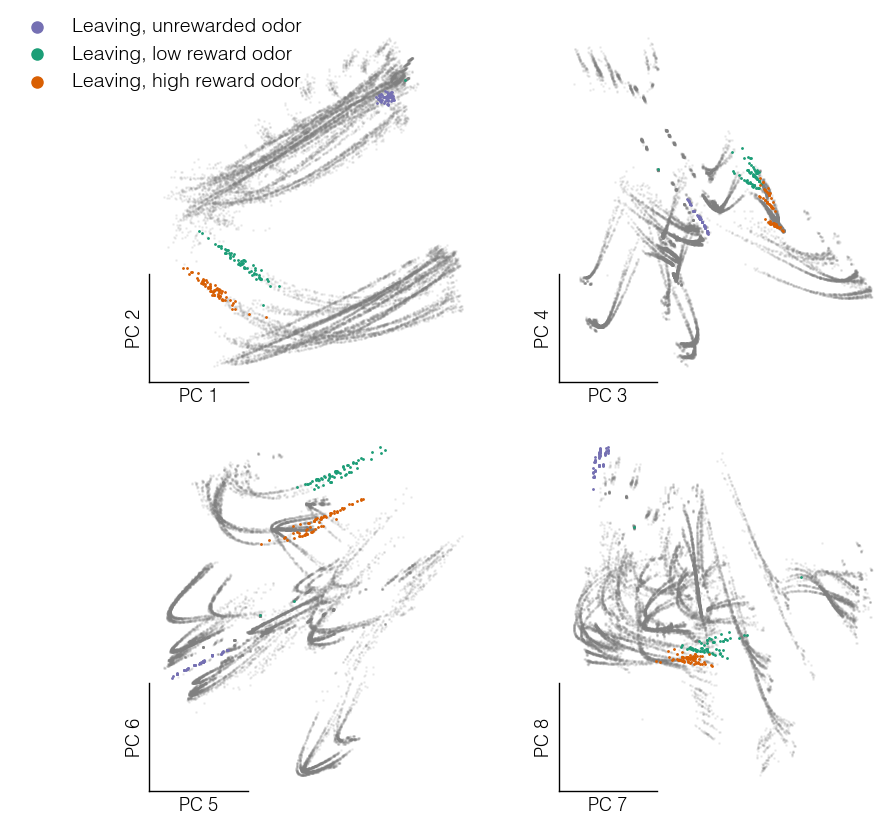

In [7]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(7 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    k_x, k_y = int(k/4), int(k/2) % 2
    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :][session_data['agent_in_patch'] <= 0],
        pc_activities[k+1, env_idx, :][session_data['agent_in_patch'] <= 0],
        s=1,
        c='grey',
        alpha=0.1,
        # vmax=2,
    )

    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :][session_data['agent_in_patch'] > 0],
        pc_activities[k+1, env_idx, :][session_data['agent_in_patch'] > 0],
        s=1,
        c='grey',
        alpha=0.1,
        # vmax=2,
    )

    labels = [
        'Leaving, unrewarded odor',
        'Leaving, low reward odor',
        'Leaving, high reward odor',
    ]

    for odor_i in range(3):
        extra_args = {}
        if k == 0:
            extra_args['label'] = labels[odor_i]
        
        leaving_site_mask = logical_and(
            session_data['agent_in_patch'] == 1,
            np.roll(session_data['agent_in_patch'], -1) == 0,
            session_data['current_patch_num'] == odor_i,
        )
    
        cbar = axs[k_x, k_y].scatter(
            pc_activities[k, env_idx, :][leaving_site_mask],
            pc_activities[k+1, env_idx, :][leaving_site_mask],
            s=1,
            c=odor_colors[odor_i],
            zorder=5,
            **extra_args,
        )
legend = fig.legend(markerscale=8, bbox_to_anchor=(0.3, 1), fontsize=14, frameon=False)
fig.tight_layout()
# axs[0, 0].set_title('Activity colored by rewards seen in patch')
# fig.tight_layout()
format_pc_plot(axs)
fig.savefig('../../results/figures/pc_patch_leaving_by_odor_he_init.svg')
fig.savefig('../../results/figures/pc_patch_leaving_by_odor_he_init.png')

Axes(0.468114,0.53;0.00915909x0.35)
Axes(0.890841,0.53;0.00915909x0.35)
Axes(0.468114,0.11;0.00915909x0.35)
Axes(0.890841,0.11;0.00915909x0.35)
[<Axes: > <Axes: > <Axes: > <Axes: >]
[<Axes: xlabel='PC 1', ylabel='PC 2'>, <Axes: xlabel='PC 3', ylabel='PC 4'>, <Axes: xlabel='PC 5', ylabel='PC 6'>, <Axes: xlabel='PC 7', ylabel='PC 8'>]


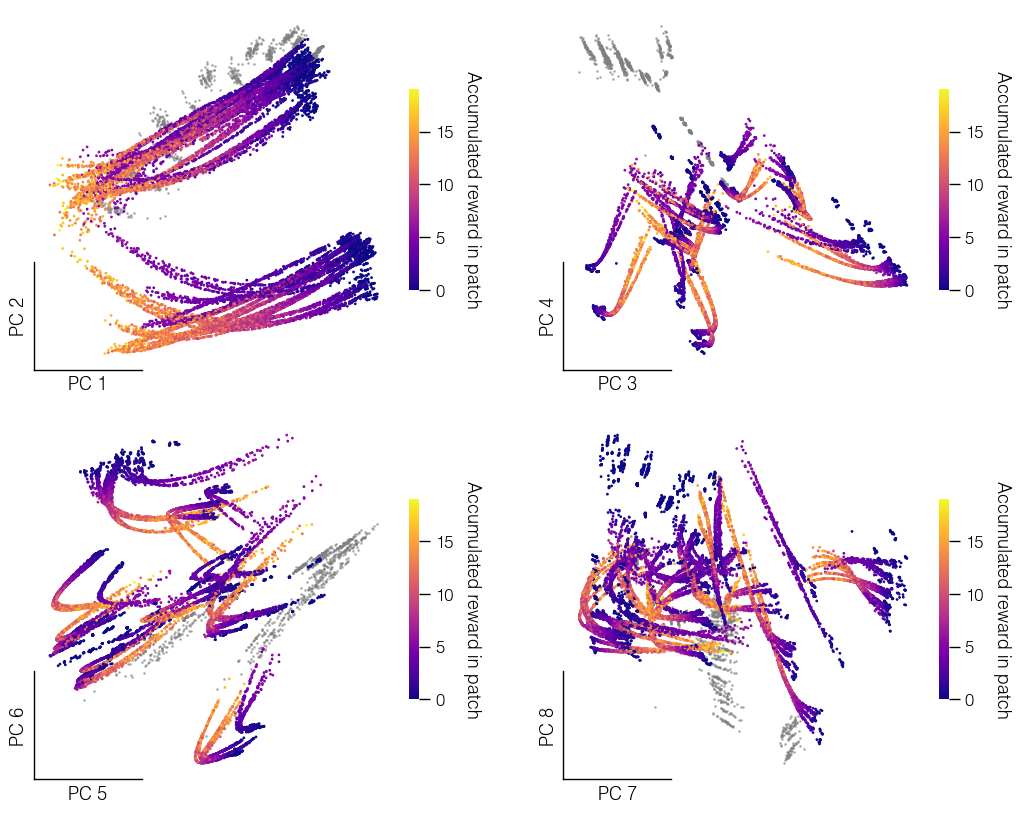

In [14]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(9 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    k_x, k_y = int(k/4), int(k/2) % 2
    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :][session_data['agent_in_patch'] <= 0],
        pc_activities[k+1, env_idx, :][session_data['agent_in_patch'] <= 0],
        s=1,
        c='grey',
        alpha=0.5,
        # vmax=2,
    )

    leaving_site_mask = logical_and(
        session_data['agent_in_patch'] == 1,
        np.roll(session_data['agent_in_patch'], -1) == 0,
    )

    # cbar = axs[k_x, k_y].scatter(
    #     pc_activities[k, env_idx, :][leaving_site_mask],
    #     pc_activities[k+1, env_idx, :][leaving_site_mask],
    #     s=1,
    #     c='red',
    #     zorder=5,
    # )

    
    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :][session_data['agent_in_patch'] > 0],
        pc_activities[k+1, env_idx, :][session_data['agent_in_patch'] > 0],
        s=1,
        c=session_data['rewards_seen_in_patch'][session_data['agent_in_patch'] > 0],
        cmap='plasma',
        vmin=0,
    )
    cbar_ax = fig.colorbar(cbar, fraction=0.026, pad=0.04)
    format_plot(cbar_ax.ax, rightspine=False, leftspine=False, topspine=False, bottomspine=False)
    cbar_ax.outline.set_visible(False)
    cbar_ax.set_label('Accumulated reward in patch', rotation=270, labelpad=20)
fig.tight_layout()
# axs[0, 0].set_title('Activity colored by rewards seen in patch')
# fig.tight_layout()
format_pc_plot(axs)
fig.savefig('../../results/figures/pc_acc_reward_he_init.svg')
fig.savefig('../../results/figures/pc_acc_reward_he_init.png')

C:\Users\david.bell\AppData\Local\Temp\ipykernel_21740\2629933764.py:30: RuntimeWarning: invalid value encountered in divide
  reward_probs = 0.8 * np.exp(-session_data['rewards_seen_in_patch'][session_data['agent_in_patch'] > 0] / reward_params)


Axes(0.468114,0.53;0.00915909x0.35)
Axes(0.890841,0.53;0.00915909x0.35)
Axes(0.468114,0.11;0.00915909x0.35)
Axes(0.890841,0.11;0.00915909x0.35)
[<Axes: > <Axes: > <Axes: > <Axes: >]
[<Axes: xlabel='PC 1', ylabel='PC 2'>, <Axes: xlabel='PC 3', ylabel='PC 4'>, <Axes: xlabel='PC 5', ylabel='PC 6'>, <Axes: xlabel='PC 7', ylabel='PC 8'>]


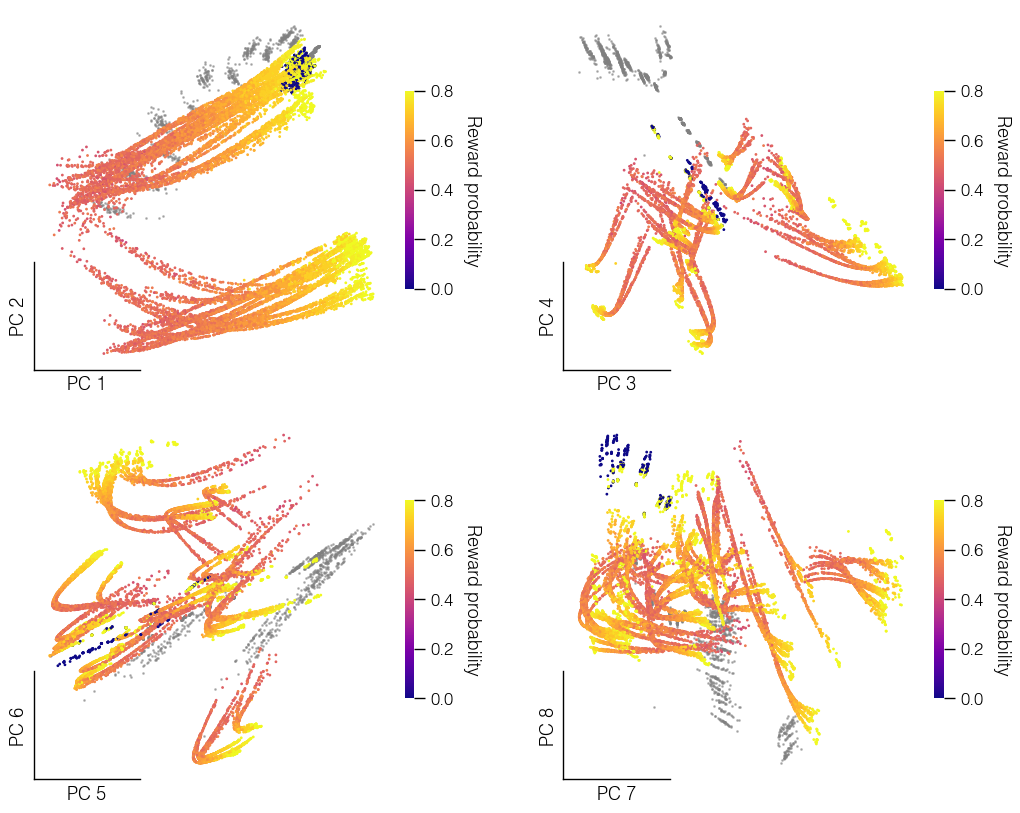

In [15]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(9 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    k_x, k_y = int(k/4), int(k/2) % 2
    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :][session_data['agent_in_patch'] <= 0],
        pc_activities[k+1, env_idx, :][session_data['agent_in_patch'] <= 0],
        s=1,
        c='grey',
        alpha=0.5,
        # vmax=2,
    )

    leaving_site_mask = logical_and(
        session_data['agent_in_patch'] == 1,
        np.roll(session_data['agent_in_patch'], -1) == 0,
    )

    # cbar = axs[k_x, k_y].scatter(
    #     pc_activities[k, env_idx, :][leaving_site_mask],
    #     pc_activities[k+1, env_idx, :][leaving_site_mask],
    #     s=1,
    #     c='red',
    #     zorder=5,
    # )

    reward_params_for_odors = np.array([0, 10, 30])
    reward_params = reward_params_for_odors[session_data['current_patch_num'][session_data['agent_in_patch'] > 0].astype(int)]
    reward_probs = 0.8 * np.exp(-session_data['rewards_seen_in_patch'][session_data['agent_in_patch'] > 0] / reward_params)
    reward_probs[session_data['current_patch_num'][session_data['agent_in_patch'] > 0] == 0] = 0

    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :][session_data['agent_in_patch'] > 0],
        pc_activities[k+1, env_idx, :][session_data['agent_in_patch'] > 0],
        s=1,
        c=reward_probs,
        cmap='plasma',
    )
    cbar_ax = fig.colorbar(cbar, fraction=0.026, pad=0.04)
    format_plot(cbar_ax.ax, rightspine=False, leftspine=False, topspine=False, bottomspine=False)
    cbar_ax.outline.set_visible(False)
    cbar_ax.set_label('Reward probability', rotation=270, labelpad=20)
fig.tight_layout()
# axs[0, 0].set_title('Activity colored by rewards seen in patch')
# fig.tight_layout()
format_pc_plot(axs)
fig.savefig('../../results/figures/pc_reward_probability_he_init.svg')
fig.savefig('../../results/figures/pc_reward_probability_he_init.png')

Axes(0.468114,0.53;0.00915909x0.35)
Axes(0.890841,0.53;0.00915909x0.35)
Axes(0.468114,0.11;0.00915909x0.35)
Axes(0.890841,0.11;0.00915909x0.35)
[<Axes: > <Axes: > <Axes: > <Axes: >]
[<Axes: xlabel='PC 1', ylabel='PC 2'>, <Axes: xlabel='PC 3', ylabel='PC 4'>, <Axes: xlabel='PC 5', ylabel='PC 6'>, <Axes: xlabel='PC 7', ylabel='PC 8'>]


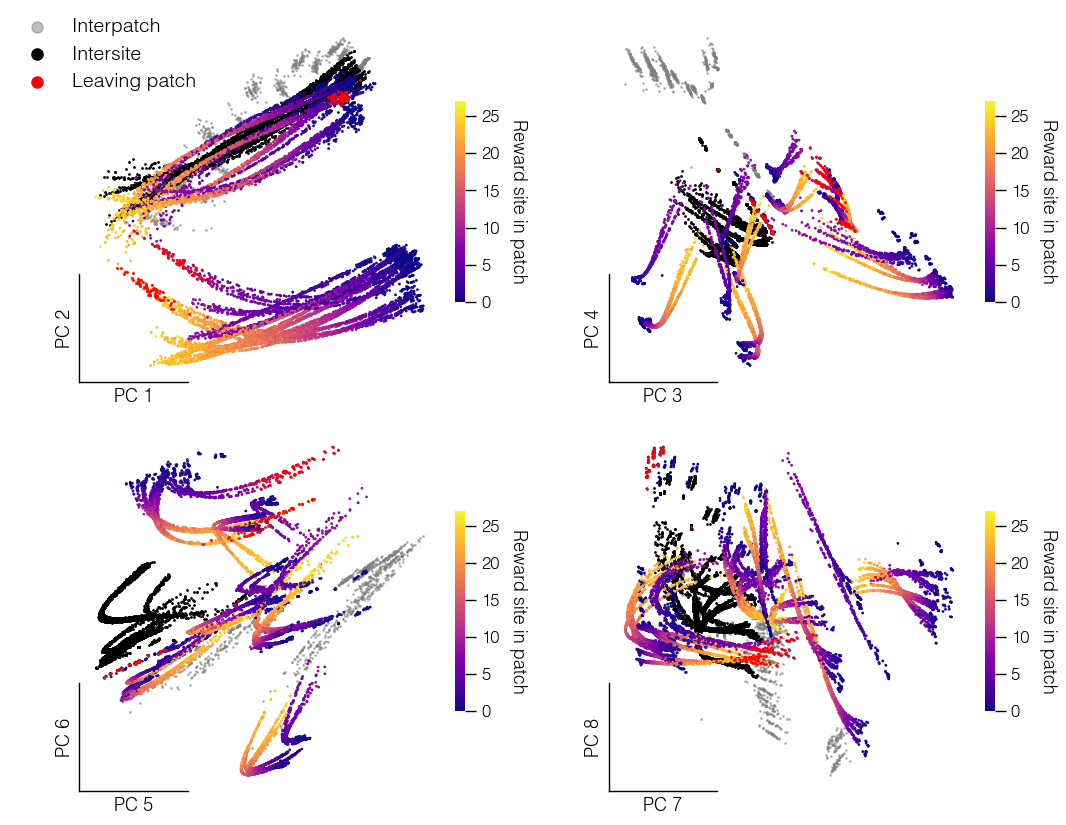

In [16]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(9 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    k_x, k_y = int(k/4), int(k/2) % 2

    extra_args = {}
    if k == 0:
        extra_args['label'] = 'Interpatch'
    
    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :][session_data['agent_in_patch'] <= 0],
        pc_activities[k+1, env_idx, :][session_data['agent_in_patch'] <= 0],
        s=1,
        c='grey',
        alpha=0.5,
        **extra_args,
    )

    in_patch_out_of_site_mask = logical_and(
        session_data['agent_in_patch'] > 0,
        session_data['reward_site_idx'] == -1,
    )

    extra_args = {}
    if k == 0:
        extra_args['label'] = 'Intersite'
        
    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :][in_patch_out_of_site_mask],
        pc_activities[k+1, env_idx, :][in_patch_out_of_site_mask],
        s=1,
        c='black',
        **extra_args,
    )

    leaving_site_mask = logical_and(
        session_data['agent_in_patch'] == 1,
        np.roll(session_data['agent_in_patch'], -1) == 0,
    )

    extra_args = {}
    if k == 0:
        extra_args['label'] = 'Leaving patch'

    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :][leaving_site_mask],
        pc_activities[k+1, env_idx, :][leaving_site_mask],
        s=1,
        c='red',
        zorder=5,
        **extra_args,
    )

    in_patch_in_site_mask = logical_and(
        session_data['agent_in_patch'] > 0,
        session_data['reward_site_idx'] >= 0,
    )
    
    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :][in_patch_in_site_mask],
        pc_activities[k+1, env_idx, :][in_patch_in_site_mask],
        s=1,
        c=session_data['reward_site_idx'][in_patch_in_site_mask],
        cmap='plasma',
        vmin=0,
    )

    cbar_ax = fig.colorbar(cbar, fraction=0.026, pad=0.04)
    format_plot(cbar_ax.ax, rightspine=False, leftspine=False, topspine=False, bottomspine=False)
    cbar_ax.outline.set_visible(False)
    cbar_ax.set_label('Reward site in patch', rotation=270, labelpad=20)
# axs[0, 0].set_title('Activity colored by rewards seen in patch')
legend = fig.legend(markerscale=8, bbox_to_anchor=(0.2, 1), fontsize=14, frameon=False)
fig.tight_layout()
format_pc_plot(axs)
# fig.tight_layout()
fig.savefig('../../results/figures/pc_reward_site_he_init.svg')
fig.savefig('../../results/figures/pc_reward_site_he_init.png')

[<Axes: > <Axes: > <Axes: > <Axes: >]
[<Axes: xlabel='PC 1', ylabel='PC 2'>, <Axes: xlabel='PC 3', ylabel='PC 4'>, <Axes: xlabel='PC 5', ylabel='PC 6'>, <Axes: xlabel='PC 7', ylabel='PC 8'>]


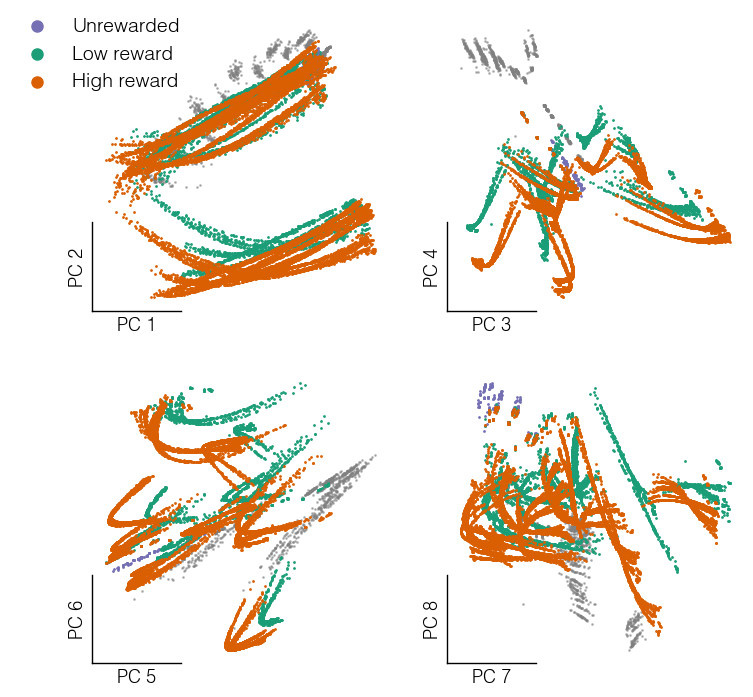

In [11]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(7 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    k_x, k_y = int(k/4), int(k/2) % 2
    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :][session_data['agent_in_patch'] <= 0],
        pc_activities[k+1, env_idx, :][session_data['agent_in_patch'] <= 0],
        s=1,
        c='grey',
        alpha=0.5,
        # vmax=2,
    )

    colors = odor_colors

    labels = [
        'Unrewarded',
        'Low reward',
        'High reward',
    ]
    
    for i in range(3):
        mask = logical_and(session_data['agent_in_patch'] > 0, session_data['current_patch_num'] == i)
        if k == 0:
            cbar = axs[k_x, k_y].scatter(
                pc_activities[k, env_idx, :][mask],
                pc_activities[k+1, env_idx, :][mask],
                s=1,
                color=colors[i],
                label=labels[i],
            )
        else:
            cbar = axs[k_x, k_y].scatter(
                pc_activities[k, env_idx, :][mask],
                pc_activities[k+1, env_idx, :][mask],
                s=1,
                color=colors[i],
            )
    # cbar_ax = fig.colorbar(cbar)
    # format_plot(cbar_ax.ax, rightspine=False, leftspine=False, topspine=False, bottomspine=False)
    # cbar_ax.outline.set_visible(False)
# axs[0, 0].set_title('Activity colored by rewards seen in patch')
legend = fig.legend(markerscale=8, bbox_to_anchor=(0.25, .9), fontsize=14, frameon=False)
# fig.tight_layout()
format_pc_plot(axs)
fig.savefig('../../results/figures/pc_odor_he_init.svg')
fig.savefig('../../results/figures/pc_odor_he_init.png')

Axes(0.468114,0.53;0.00915909x0.35)
Axes(0.890841,0.53;0.00915909x0.35)
Axes(0.468114,0.11;0.00915909x0.35)
Axes(0.890841,0.11;0.00915909x0.35)
[<Axes: > <Axes: > <Axes: > <Axes: >]
[<Axes: xlabel='PC 1', ylabel='PC 2'>, <Axes: xlabel='PC 3', ylabel='PC 4'>, <Axes: xlabel='PC 5', ylabel='PC 6'>, <Axes: xlabel='PC 7', ylabel='PC 8'>]


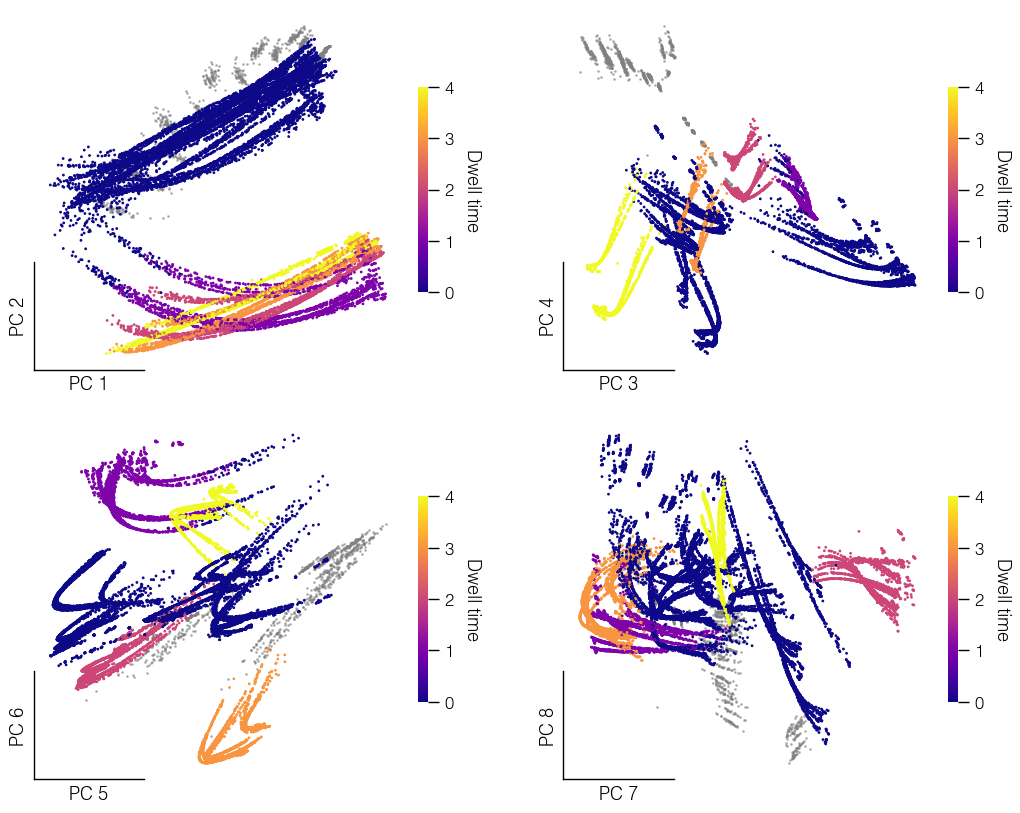

In [17]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(9 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    k_x, k_y = int(k/4), int(k/2) % 2
    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :][session_data['agent_in_patch'] <= 0],
        pc_activities[k+1, env_idx, :][session_data['agent_in_patch'] <= 0],
        s=1,
        c='grey',
        alpha=0.5,
        # vmax=2,
    )
    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :][session_data['agent_in_patch'] > 0],
        pc_activities[k+1, env_idx, :][session_data['agent_in_patch'] > 0],
        s=1,
        c=session_data['dwell_time'][session_data['agent_in_patch'] > 0],
        cmap='plasma',
        vmin=0,
    )
    cbar_ax = fig.colorbar(cbar, fraction=0.026, pad=0.04)
    format_plot(cbar_ax.ax, rightspine=False, leftspine=False, topspine=False, bottomspine=False)
    cbar_ax.outline.set_visible(False)
    cbar_ax.set_label('Dwell time', rotation=270, labelpad=20)
# axs[0, 0].set_title('Activity colored by rewards seen in patch')
fig.tight_layout()
format_pc_plot(axs)
fig.savefig('../../results/figures/pc_dwell_time_he_init.svg')
fig.savefig('../../results/figures/pc_dwell_time_he_init.png')

In [33]:
def extract_rep_direction(hidden_activities, all_session_data, var, in_patch=False):
    rep_directions = []
    for env_i in range(len(all_session_data)):
        session_data = all_session_data[env_i]
        min_val, max_val = session_data[var].min(), session_data[var].max()
        in_patch_mask = session_data['agent_in_patch'] == 1
        min_mask = logical_and(in_patch_mask, session_data[var] == min_val, )
        max_mask = logical_and(in_patch_mask, session_data[var] == max_val, )
        hidden_env_i_min = hidden_activities[:, env_i, min_mask].mean(axis=-1)
        hidden_env_i_max = hidden_activities[:, env_i, max_mask].mean(axis=-1)
        rep_directions.append(hidden_env_i_max - hidden_env_i_min)
    return np.array(rep_directions).mean(axis=0)

In [34]:
rep_direction = extract_rep_direction(hidden, all_session_data, 'rewards_seen_in_patch')

In [10]:
write_path = os.path.join(dir_path, 'stored_pcs_and_weights')
make_path_if_not_exists(write_path)
compressed_write(rep_direction, os.path.join(write_path, 'rewards_seen_in_patch.pkl').replace('\\','/'))

In [64]:
def extract_rep_direction_decoder(hidden_activities, all_session_data, var, in_patch=False):
    rep_directions = []

    hidden_in_patch = []
    var_in_patch = []
    
    for env_i in range(len(all_session_data)):
        session_data = all_session_data[env_i]
        in_patch_mask = session_data['agent_in_patch'] == 1
        hidden_in_patch.append(hidden_activities[:, env_i, in_patch_mask])
        var_in_patch.append(session_data[var][in_patch_mask])

    hidden_in_patch = np.concatenate(hidden_in_patch, axis=1).T
    var_in_patch = np.concatenate(var_in_patch)

    coefs = []
    r2_scores = []
    kf = KFold(n_splits=5, shuffle=True)
    for train_idx, test_idx in kf.split(hidden_in_patch):
        X_train, X_test = hidden_in_patch[train_idx, :], hidden_in_patch[test_idx, :]
        Y_train, Y_test = var_in_patch[train_idx], var_in_patch[test_idx]
        # Train logistic regression
        model = LinearRegression()
        model.fit(X_train, Y_train)
        # Compute R^2 score
        Y_pred = model.predict(X_test)
        r2_scores.append(r2_score(Y_test, Y_pred))
        coefs.append(model.coef_.flatten())

    return coefs

In [65]:
decoder_rep_directions = extract_rep_direction_decoder(hidden, all_session_data, 'rewards_seen_in_patch')

In [66]:
decoder_rep_directions = np.array(rep_directions)

In [70]:
write_path = os.path.join(dir_path, 'stored_pcs_and_weights')
make_path_if_not_exists(write_path)
for i in range(decoder_rep_directions.shape[0]):
    compressed_write(decoder_rep_directions[i, :], os.path.join(write_path, f'rewards_seen_in_patch_{i}.pkl').replace('\\','/'))

In [67]:
print(compute_cosine_sims(decoder_rep_directions, decoder_rep_directions))

[ 1.0000001  -0.96354073  0.9993066  ... -0.978466    0.99998456
  0.9999999 ]


In [69]:
print(rep_direction[np.newaxis, :].shape)
print(decoder_rep_directions.shape)
print(compute_cosine_sims(decoder_rep_directions, rep_direction[np.newaxis, :], axis=0))

(1, 128)
(5, 128)
[0.00722094 0.00717495 0.0071776  0.00718764 0.00725427]


### Compute q values (kinetic energy)

In [18]:
q = 0.5 * np.sum(np.square(hidden[..., 1:] - hidden[..., :-1]), axis=0)

#### For odor 1, color states by q value.

Axes(0.468114,0.53;0.00915909x0.35)
Axes(0.890841,0.53;0.00915909x0.35)
Axes(0.468114,0.11;0.00915909x0.35)
Axes(0.890841,0.11;0.00915909x0.35)
[<Axes: > <Axes: > <Axes: > <Axes: >]
[<Axes: xlabel='PC 1', ylabel='PC 2'>, <Axes: xlabel='PC 3', ylabel='PC 4'>, <Axes: xlabel='PC 5', ylabel='PC 6'>, <Axes: xlabel='PC 7', ylabel='PC 8'>]


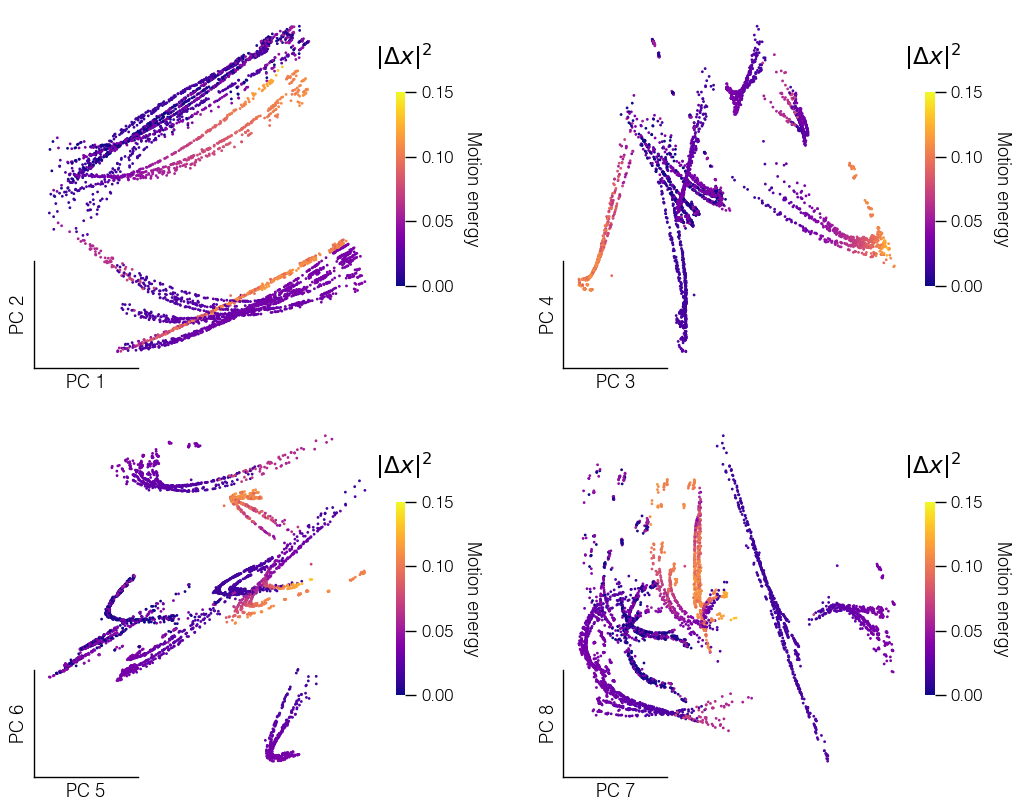

In [26]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(9 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    k_x, k_y = int(k/4), int(k/2) % 2

    odor_1_mask = logical_and(session_data['current_patch_num'][:-1] == 1, session_data['agent_in_patch'][:-1])
    
    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :-1][odor_1_mask],
        pc_activities[k+1, env_idx, :-1][odor_1_mask],
        s=1,
        c=q[env_idx][odor_1_mask],
        cmap='plasma',
        vmin=0,
        vmax=0.15,
    )
    cbar_ax = fig.colorbar(cbar, fraction=0.026, pad=0.04)
    format_plot(cbar_ax.ax, rightspine=False, leftspine=False, topspine=False, bottomspine=False)
    cbar_ax.outline.set_visible(False)
    cbar_ax.ax.set_title(r' $|\Delta x|^2$', pad=20)
    cbar_ax.set_label('Motion energy', rotation=270, labelpad=20)
# axs[0, 0].set_title('Activity colored by rewards seen in patch')
fig.tight_layout()
format_pc_plot(axs)

#### For odor 2, color states by q value.

Axes(0.468114,0.53;0.00915909x0.35)
Axes(0.890841,0.53;0.00915909x0.35)
Axes(0.468114,0.11;0.00915909x0.35)
Axes(0.890841,0.11;0.00915909x0.35)
[<Axes: > <Axes: > <Axes: > <Axes: >]
[<Axes: xlabel='PC 1', ylabel='PC 2'>, <Axes: xlabel='PC 3', ylabel='PC 4'>, <Axes: xlabel='PC 5', ylabel='PC 6'>, <Axes: xlabel='PC 7', ylabel='PC 8'>]


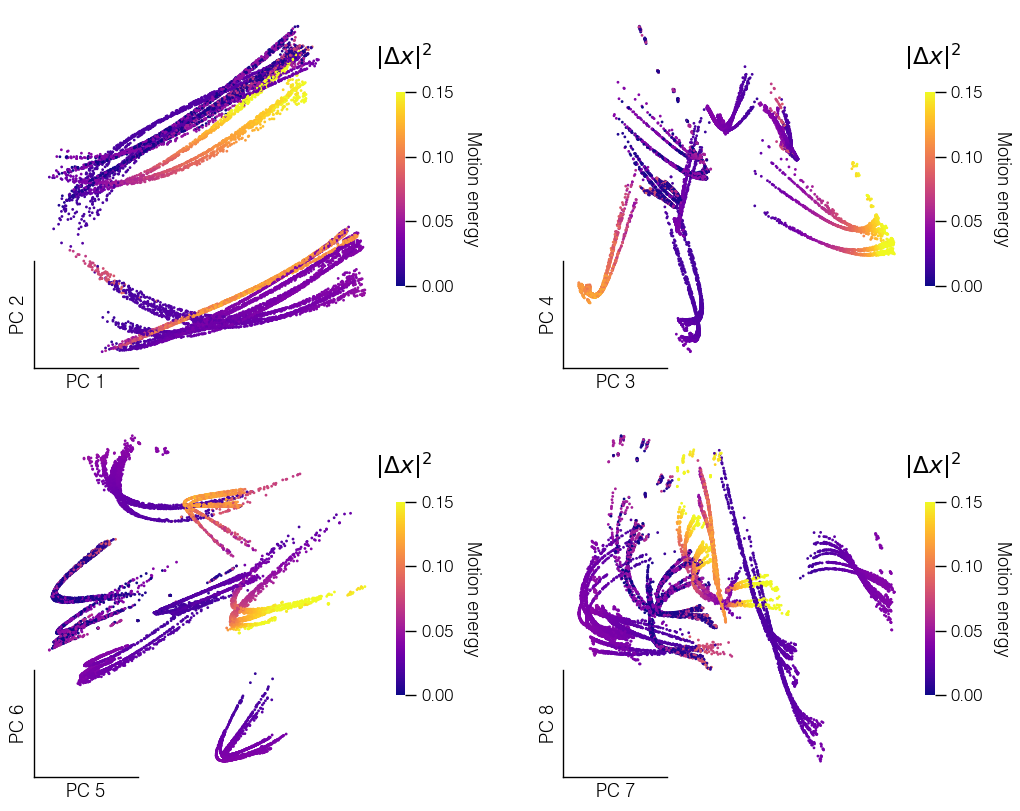

In [27]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(9 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    k_x, k_y = int(k/4), int(k/2) % 2

    odor_2_mask = logical_and(session_data['current_patch_num'][:-1] == 2, session_data['agent_in_patch'][:-1])
    
    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :-1][odor_2_mask],
        pc_activities[k+1, env_idx, :-1][odor_2_mask],
        s=1,
        c=q[env_idx][odor_2_mask],
        cmap='plasma',
        vmin=0,
        vmax=0.15,
    )
    cbar_ax = fig.colorbar(cbar, fraction=0.026, pad=0.04)
    format_plot(cbar_ax.ax, rightspine=False, leftspine=False, topspine=False, bottomspine=False)
    cbar_ax.outline.set_visible(False)
    cbar_ax.ax.set_title(r' $|\Delta x|^2$', pad=20)
    cbar_ax.set_label('Motion energy', rotation=270, labelpad=20)
# axs[0, 0].set_title('Activity colored by rewards seen in patch')
fig.tight_layout()
format_pc_plot(axs)

### Only show states where agent is rewarded

Compute for odor 1

Axes(0.468114,0.53;0.00915909x0.35)
Axes(0.890841,0.53;0.00915909x0.35)
Axes(0.468114,0.11;0.00915909x0.35)
Axes(0.890841,0.11;0.00915909x0.35)
[<Axes: > <Axes: > <Axes: > <Axes: >]
[<Axes: xlabel='PC 1', ylabel='PC 2'>, <Axes: xlabel='PC 3', ylabel='PC 4'>, <Axes: xlabel='PC 5', ylabel='PC 6'>, <Axes: xlabel='PC 7', ylabel='PC 8'>]


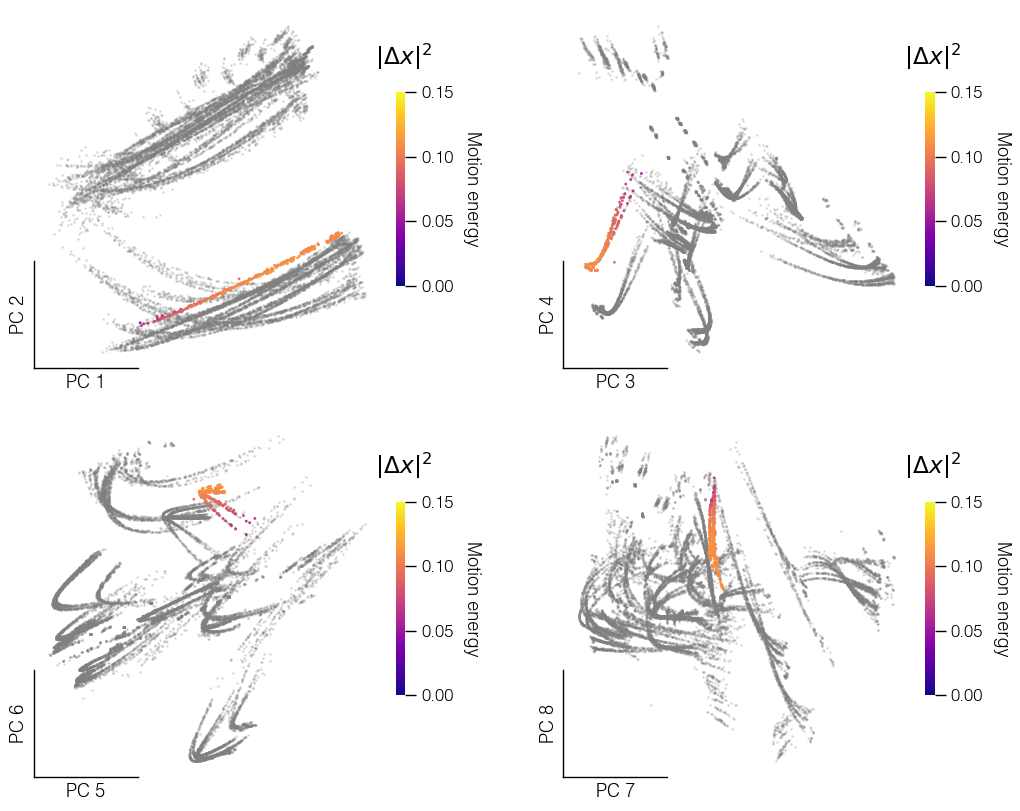

In [28]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(9 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    k_x, k_y = int(k/4), int(k/2) % 2

    odor_1_mask = logical_and(session_data['current_patch_num'][:-1] == 1, np.roll(session_data['reward'][:-1], 0) > 0)

    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :-1][~odor_1_mask],
        pc_activities[k+1, env_idx, :-1][~odor_1_mask],
        s=1,
        color='grey',
        alpha=0.2
    )
    
    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :-1][odor_1_mask],
        pc_activities[k+1, env_idx, :-1][odor_1_mask],
        s=1,
        c=q[env_idx][odor_1_mask],
        cmap='plasma',
        vmin=0,
        vmax=0.15,
    )
    cbar_ax = fig.colorbar(cbar, fraction=0.026, pad=0.04)
    format_plot(cbar_ax.ax, rightspine=False, leftspine=False, topspine=False, bottomspine=False)
    cbar_ax.outline.set_visible(False)
    cbar_ax.ax.set_title(r' $|\Delta x|^2$', pad=20)
    cbar_ax.set_label('Motion energy', rotation=270, labelpad=20)
# axs[0, 0].set_title('Activity colored by rewards seen in patch')
fig.tight_layout()
format_pc_plot(axs)

For odor 2

Axes(0.468114,0.53;0.00915909x0.35)
Axes(0.890841,0.53;0.00915909x0.35)
Axes(0.468114,0.11;0.00915909x0.35)
Axes(0.890841,0.11;0.00915909x0.35)
[<Axes: > <Axes: > <Axes: > <Axes: >]
[<Axes: xlabel='PC 1', ylabel='PC 2'>, <Axes: xlabel='PC 3', ylabel='PC 4'>, <Axes: xlabel='PC 5', ylabel='PC 6'>, <Axes: xlabel='PC 7', ylabel='PC 8'>]


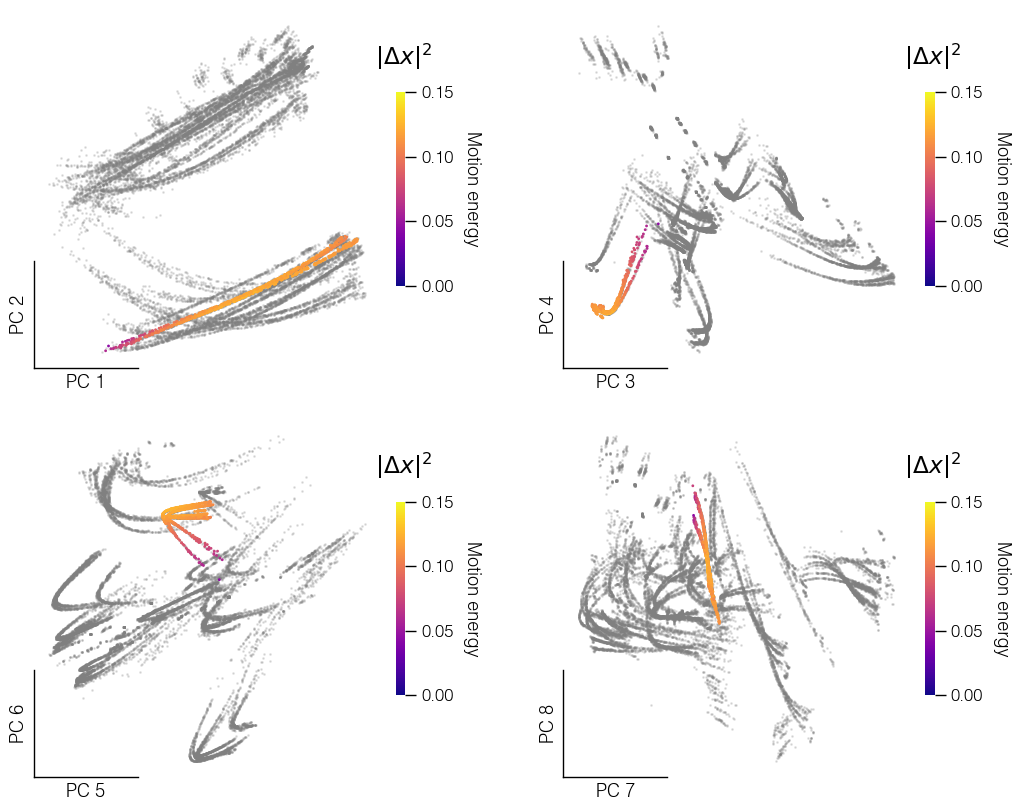

In [29]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(9 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    k_x, k_y = int(k/4), int(k/2) % 2

    odor_2_mask = logical_and(session_data['current_patch_num'][:-1] == 2, np.roll(session_data['reward'][:-1], 0) > 0)

    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :-1][~odor_2_mask],
        pc_activities[k+1, env_idx, :-1][~odor_2_mask],
        s=1,
        color='grey',
        alpha=0.2
    )
    
    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :-1][odor_2_mask],
        pc_activities[k+1, env_idx, :-1][odor_2_mask],
        s=1,
        c=q[env_idx][odor_2_mask],
        cmap='plasma',
        vmin=0,
        vmax=0.15,
    )
    cbar_ax = fig.colorbar(cbar, fraction=0.026, pad=0.04)
    format_plot(cbar_ax.ax, rightspine=False, leftspine=False, topspine=False, bottomspine=False)
    cbar_ax.outline.set_visible(False)
    cbar_ax.ax.set_title(r' $|\Delta x|^2$', pad=20)
    cbar_ax.set_label('Motion energy', rotation=270, labelpad=20)
# axs[0, 0].set_title('Activity colored by rewards seen in patch')
fig.tight_layout()
format_pc_plot(axs)

### Compute component of q that is just along acc. reward direction

In [35]:
delta_h = hidden[..., 1:] - hidden[..., :-1]
rep_direction_norm = rep_direction / np.linalg.norm(rep_direction)
delta_h_proj_rep_direction = np.tensordot(delta_h, rep_direction_norm, ([0], [0]))
delta_h_proj_rep_direction.shape

q_along_rep_direction = 0.5 * np.square(delta_h_proj_rep_direction)

Axes(0.468114,0.53;0.00915909x0.35)
Axes(0.890841,0.53;0.00915909x0.35)
Axes(0.468114,0.11;0.00915909x0.35)
Axes(0.890841,0.11;0.00915909x0.35)
[<Axes: > <Axes: > <Axes: > <Axes: >]
[<Axes: xlabel='PC 1', ylabel='PC 2'>, <Axes: xlabel='PC 3', ylabel='PC 4'>, <Axes: xlabel='PC 5', ylabel='PC 6'>, <Axes: xlabel='PC 7', ylabel='PC 8'>]


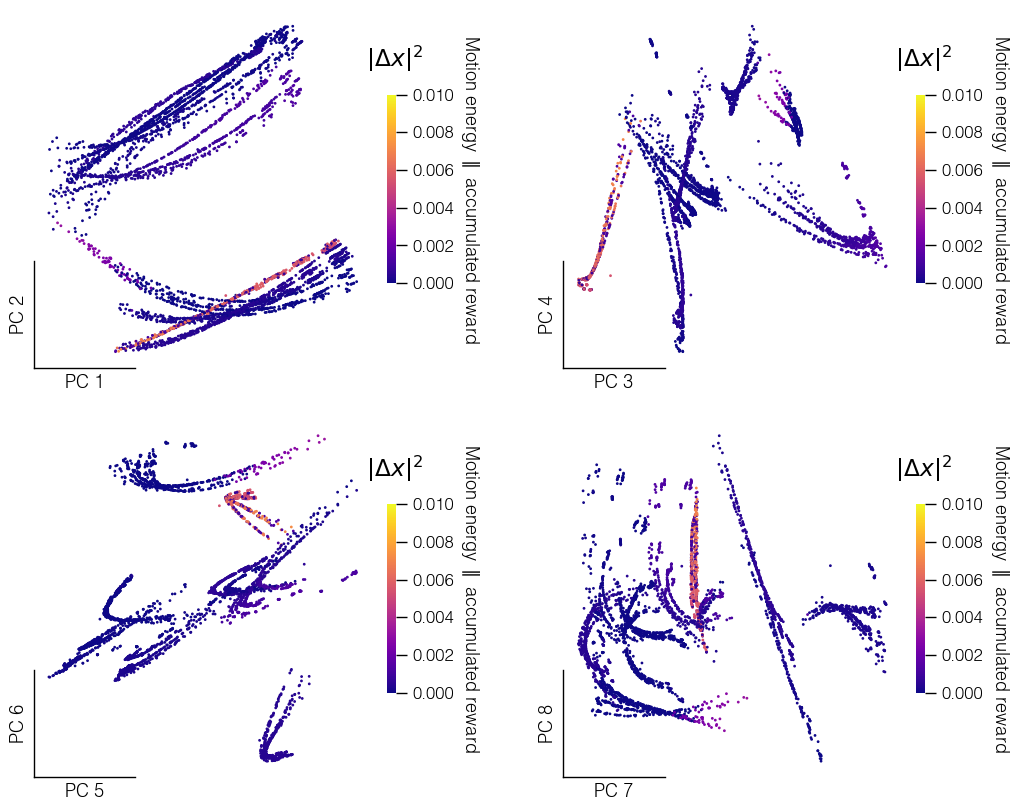

In [45]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(9 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    k_x, k_y = int(k/4), int(k/2) % 2

    odor_1_mask = logical_and(session_data['current_patch_num'][:-1] == 1, session_data['agent_in_patch'][:-1])
    
    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :-1][odor_1_mask],
        pc_activities[k+1, env_idx, :-1][odor_1_mask],
        s=1,
        c=q_along_rep_direction[env_idx][odor_1_mask],
        cmap='plasma',
        vmin=0,
        vmax=0.01,
    )
    cbar_ax = fig.colorbar(cbar, fraction=0.026, pad=0.04)
    format_plot(cbar_ax.ax, rightspine=False, leftspine=False, topspine=False, bottomspine=False)
    cbar_ax.outline.set_visible(False)
    cbar_ax.ax.set_title(r' $|\Delta x|^2$', pad=20)
    cbar_ax.set_label('Motion energy ' + r'$\parallel$' + ' accumulated reward', rotation=270, labelpad=20)
# axs[0, 0].set_title('Activity colored by rewards seen in patch')
fig.tight_layout()
format_pc_plot(axs)
fig.savefig('../../results/figures/pc_q_along_acc_reward_low_reward_odor.svg')
fig.savefig('../../results/figures/pc_q_along_acc_reward_low_reward_odor.png')

Axes(0.468114,0.53;0.00915909x0.35)
Axes(0.890841,0.53;0.00915909x0.35)
Axes(0.468114,0.11;0.00915909x0.35)
Axes(0.890841,0.11;0.00915909x0.35)
[<Axes: > <Axes: > <Axes: > <Axes: >]
[<Axes: xlabel='PC 1', ylabel='PC 2'>, <Axes: xlabel='PC 3', ylabel='PC 4'>, <Axes: xlabel='PC 5', ylabel='PC 6'>, <Axes: xlabel='PC 7', ylabel='PC 8'>]


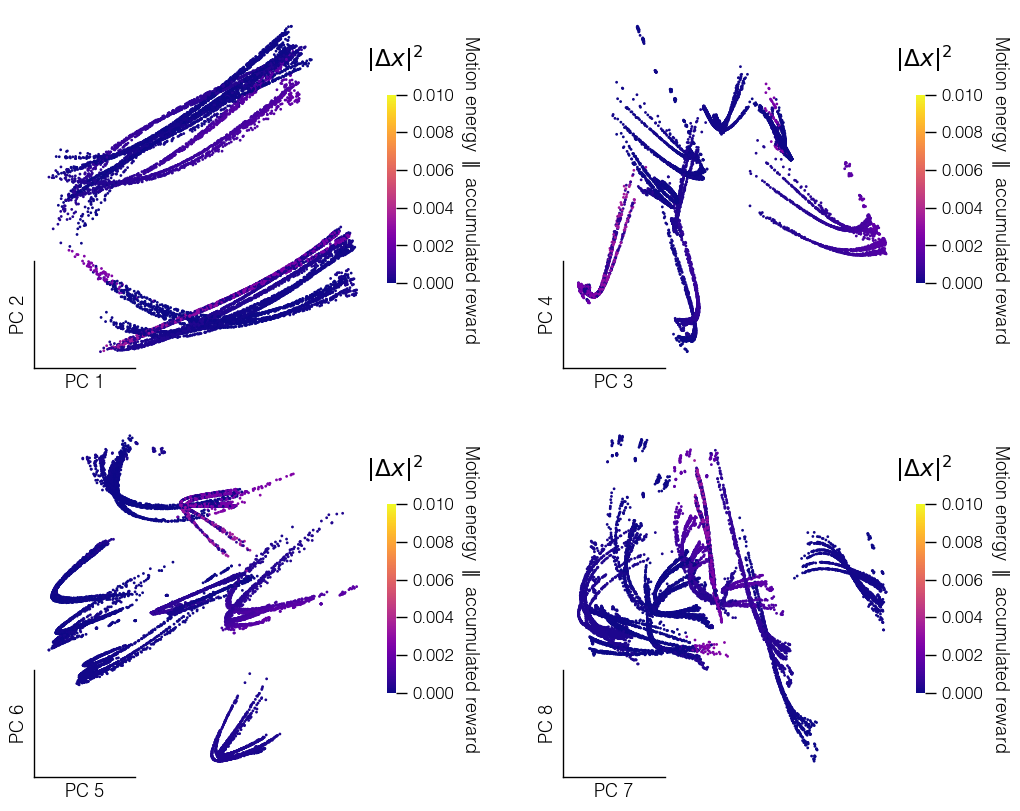

In [46]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(9 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    k_x, k_y = int(k/4), int(k/2) % 2

    odor_2_mask = logical_and(session_data['current_patch_num'][:-1] == 2, session_data['agent_in_patch'][:-1])
    
    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :-1][odor_2_mask],
        pc_activities[k+1, env_idx, :-1][odor_2_mask],
        s=1,
        c=q_along_rep_direction[env_idx][odor_2_mask],
        cmap='plasma',
        vmin=0,
        vmax=0.01,
    )
    cbar_ax = fig.colorbar(cbar, fraction=0.026, pad=0.04)
    format_plot(cbar_ax.ax, rightspine=False, leftspine=False, topspine=False, bottomspine=False)
    cbar_ax.outline.set_visible(False)
    cbar_ax.ax.set_title(r' $|\Delta x|^2$', pad=20)
    cbar_ax.set_label('Motion energy ' + r'$\parallel$' + ' accumulated reward', rotation=270, labelpad=20)
# axs[0, 0].set_title('Activity colored by rewards seen in patch')
fig.tight_layout()
format_pc_plot(axs)
fig.savefig('../../results/figures/pc_q_along_acc_reward_high_reward_odor.svg')
fig.savefig('../../results/figures/pc_q_along_acc_reward_high_reward_odor.png')

### Show same projection of q along acc. reward direction, but remove states where agent is rewarded

Axes(0.468114,0.53;0.00915909x0.35)
Axes(0.890841,0.53;0.00915909x0.35)
Axes(0.468114,0.11;0.00915909x0.35)
Axes(0.890841,0.11;0.00915909x0.35)
[<Axes: > <Axes: > <Axes: > <Axes: >]
[<Axes: xlabel='PC 1', ylabel='PC 2'>, <Axes: xlabel='PC 3', ylabel='PC 4'>, <Axes: xlabel='PC 5', ylabel='PC 6'>, <Axes: xlabel='PC 7', ylabel='PC 8'>]


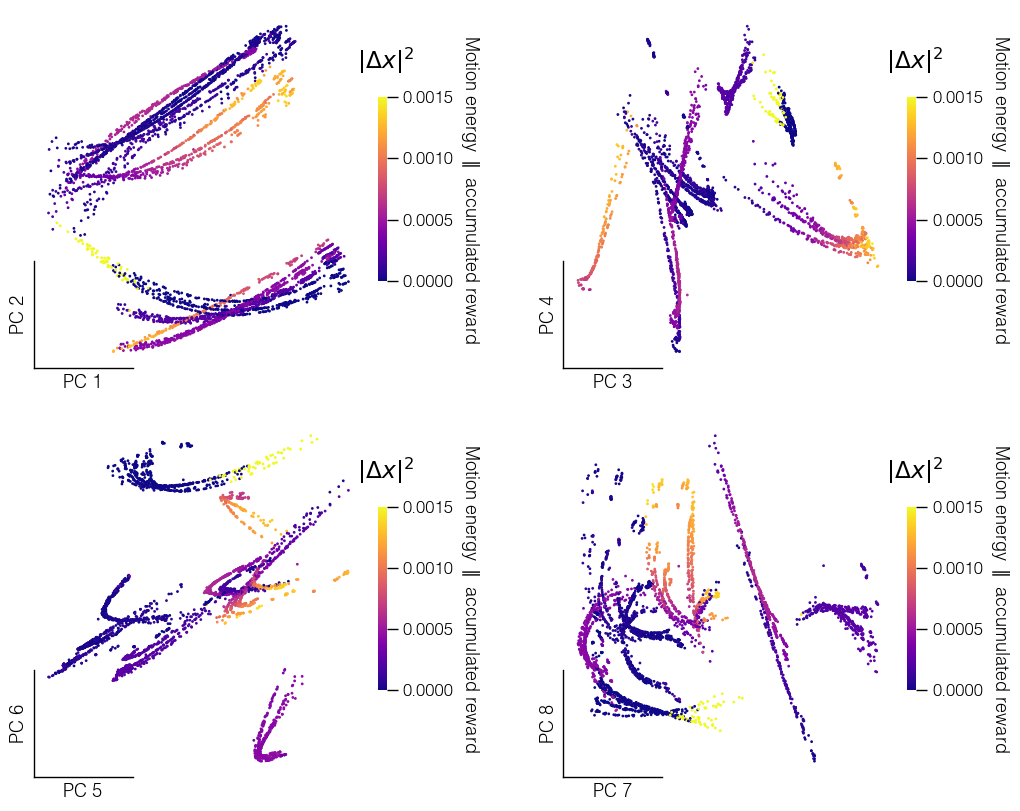

In [41]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(9 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    k_x, k_y = int(k/4), int(k/2) % 2

    odor_1_mask = logical_and(session_data['current_patch_num'][:-1] == 1, session_data['agent_in_patch'][:-1], session_data['reward'][:-1] == 0)
    
    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :-1][odor_1_mask],
        pc_activities[k+1, env_idx, :-1][odor_1_mask],
        s=1,
        c=q_along_rep_direction[env_idx][odor_1_mask],
        cmap='plasma',
        vmin=0,
        vmax=0.0015,
    )
    cbar_ax = fig.colorbar(cbar, fraction=0.026, pad=0.04)
    format_plot(cbar_ax.ax, rightspine=False, leftspine=False, topspine=False, bottomspine=False)
    cbar_ax.outline.set_visible(False)
    cbar_ax.ax.set_title(r' $|\Delta x|^2$', pad=20)
    cbar_ax.set_label('Motion energy ' + r'$\parallel$' + ' accumulated reward', rotation=270, labelpad=20)
# axs[0, 0].set_title('Activity colored by rewards seen in patch')
fig.tight_layout()
format_pc_plot(axs)

Axes(0.468114,0.53;0.00915909x0.35)
Axes(0.890841,0.53;0.00915909x0.35)
Axes(0.468114,0.11;0.00915909x0.35)
Axes(0.890841,0.11;0.00915909x0.35)
[<Axes: > <Axes: > <Axes: > <Axes: >]
[<Axes: xlabel='PC 1', ylabel='PC 2'>, <Axes: xlabel='PC 3', ylabel='PC 4'>, <Axes: xlabel='PC 5', ylabel='PC 6'>, <Axes: xlabel='PC 7', ylabel='PC 8'>]


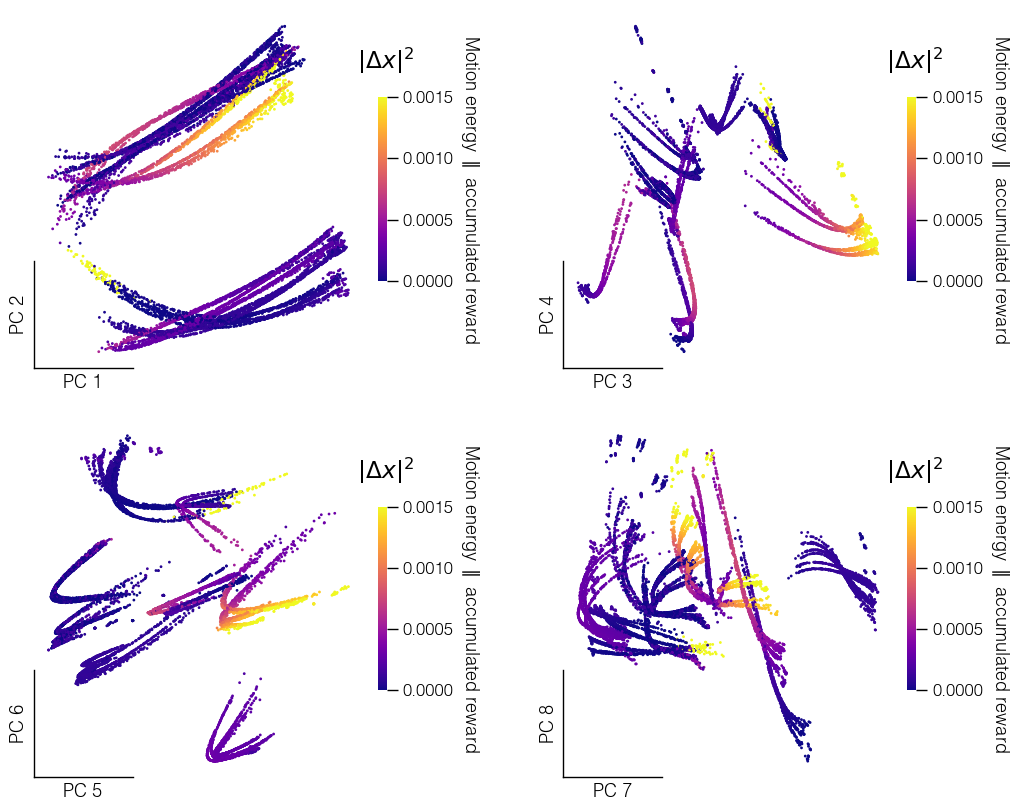

In [42]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(9 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    k_x, k_y = int(k/4), int(k/2) % 2

    odor_2_mask = logical_and(session_data['current_patch_num'][:-1] == 2, session_data['agent_in_patch'][:-1], session_data['reward'][:-1] == 0)
    
    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :-1][odor_2_mask],
        pc_activities[k+1, env_idx, :-1][odor_2_mask],
        s=1,
        c=q_along_rep_direction[env_idx][odor_2_mask],
        cmap='plasma',
        vmin=0,
        vmax=0.0015,
    )
    cbar_ax = fig.colorbar(cbar, fraction=0.026, pad=0.04)
    format_plot(cbar_ax.ax, rightspine=False, leftspine=False, topspine=False, bottomspine=False)
    cbar_ax.outline.set_visible(False)
    cbar_ax.ax.set_title(r' $|\Delta x|^2$', pad=20)
    cbar_ax.set_label('Motion energy ' + r'$\parallel$' + ' accumulated reward', rotation=270, labelpad=20)
# axs[0, 0].set_title('Activity colored by rewards seen in patch')
fig.tight_layout()
format_pc_plot(axs)

### Highlight rewarded states, color by q along acc. reward direction

Axes(0.468114,0.53;0.00915909x0.35)
Axes(0.890841,0.53;0.00915909x0.35)
Axes(0.468114,0.11;0.00915909x0.35)
Axes(0.890841,0.11;0.00915909x0.35)
[<Axes: > <Axes: > <Axes: > <Axes: >]
[<Axes: xlabel='PC 1', ylabel='PC 2'>, <Axes: xlabel='PC 3', ylabel='PC 4'>, <Axes: xlabel='PC 5', ylabel='PC 6'>, <Axes: xlabel='PC 7', ylabel='PC 8'>]


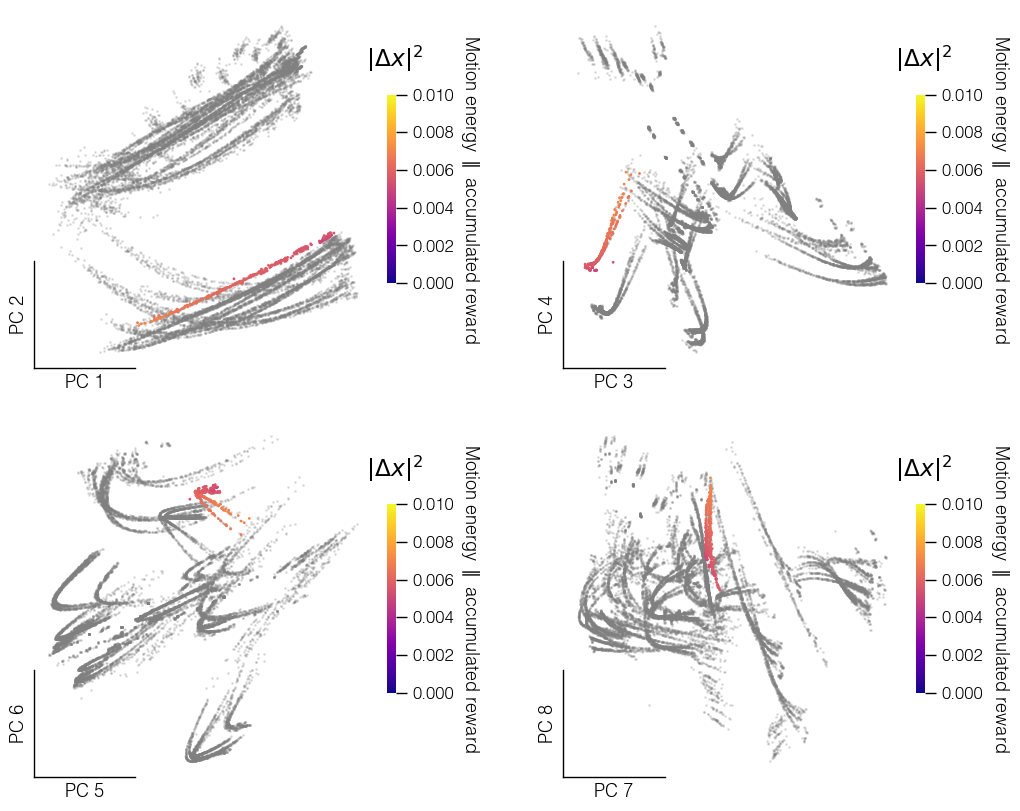

In [47]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(9 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    k_x, k_y = int(k/4), int(k/2) % 2

    odor_1_mask = logical_and(session_data['current_patch_num'][:-1] == 1, np.roll(session_data['reward'][:-1], 0) > 0)

    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :-1][~odor_1_mask],
        pc_activities[k+1, env_idx, :-1][~odor_1_mask],
        s=1,
        color='grey',
        alpha=0.2
    )
    
    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :-1][odor_1_mask],
        pc_activities[k+1, env_idx, :-1][odor_1_mask],
        s=1,
        c=q_along_rep_direction[env_idx][odor_1_mask],
        cmap='plasma',
        vmin=0,
        vmax=0.01,
    )
    cbar_ax = fig.colorbar(cbar, fraction=0.026, pad=0.04)
    format_plot(cbar_ax.ax, rightspine=False, leftspine=False, topspine=False, bottomspine=False)
    cbar_ax.outline.set_visible(False)
    cbar_ax.ax.set_title(r' $|\Delta x|^2$', pad=20)
    cbar_ax.set_label('Motion energy ' + r'$\parallel$' + ' accumulated reward', rotation=270, labelpad=20)
# axs[0, 0].set_title('Activity colored by rewards seen in patch')
fig.tight_layout()
format_pc_plot(axs)
fig.savefig('../../results/figures/pc_q_along_acc_reward_low_reward_odor_rewarded_only.svg')
fig.savefig('../../results/figures/pc_q_along_acc_reward_low_reward_odor_rewarded_only.png')

Axes(0.468114,0.53;0.00915909x0.35)
Axes(0.890841,0.53;0.00915909x0.35)
Axes(0.468114,0.11;0.00915909x0.35)
Axes(0.890841,0.11;0.00915909x0.35)
[<Axes: > <Axes: > <Axes: > <Axes: >]
[<Axes: xlabel='PC 1', ylabel='PC 2'>, <Axes: xlabel='PC 3', ylabel='PC 4'>, <Axes: xlabel='PC 5', ylabel='PC 6'>, <Axes: xlabel='PC 7', ylabel='PC 8'>]


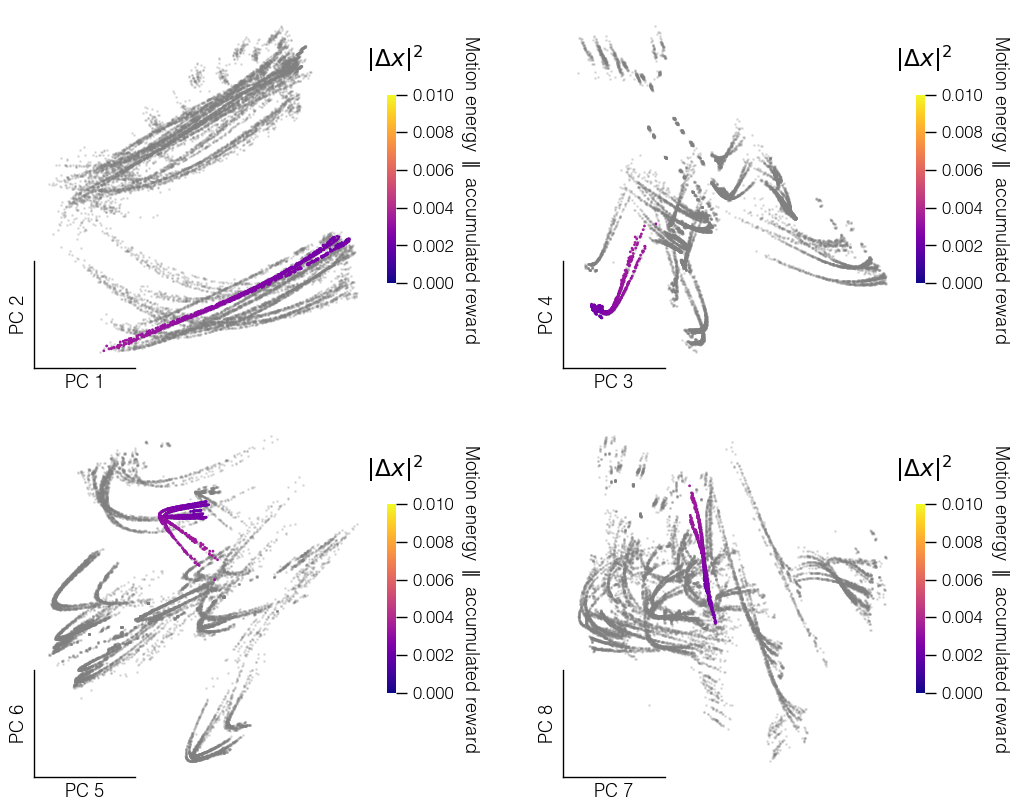

In [48]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(9 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    k_x, k_y = int(k/4), int(k/2) % 2

    odor_2_mask = logical_and(session_data['current_patch_num'][:-1] == 2, np.roll(session_data['reward'][:-1], 0) > 0)

    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :-1][~odor_2_mask],
        pc_activities[k+1, env_idx, :-1][~odor_2_mask],
        s=1,
        color='grey',
        alpha=0.2
    )
    
    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :-1][odor_2_mask],
        pc_activities[k+1, env_idx, :-1][odor_2_mask],
        s=1,
        c=q_along_rep_direction[env_idx][odor_2_mask],
        cmap='plasma',
        vmin=0,
        vmax=0.01,
    )
    cbar_ax = fig.colorbar(cbar, fraction=0.026, pad=0.04)
    format_plot(cbar_ax.ax, rightspine=False, leftspine=False, topspine=False, bottomspine=False)
    cbar_ax.outline.set_visible(False)
    cbar_ax.ax.set_title(r' $|\Delta x|^2$', pad=20)
    cbar_ax.set_label('Motion energy ' + r'$\parallel$' + ' accumulated reward', rotation=270, labelpad=20)
# axs[0, 0].set_title('Activity colored by rewards seen in patch')
fig.tight_layout()
format_pc_plot(axs)
fig.savefig('../../results/figures/pc_q_along_acc_reward_high_reward_odor_rewarded_only.svg')
fig.savefig('../../results/figures/pc_q_along_acc_reward_high_reward_odor_rewarded_only.png')